In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

### First we set a seed for deterministic output and ease of reproducability.

In [2]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # ensures deterministic algorithms
    torch.backends.cudnn.benchmark = False     # can slow down, but more reproducible

set_seed(42)

### Now we create the RNN and DataSet classes for our weather predictions.

In [3]:
class WeatherRNN(nn.Module):
  def __init__(self, input_size:int, hidden_size:int, output_size:int, num_layers:int=1, rnn_type:str='RNN', dropout:float=0.0):
    super().__init__()

    # potential RNN classes
    rnn_options = {"RNN": nn.RNN,
                   "LSTM": nn.LSTM,
                   "GRU": nn.GRU}

    if rnn_type not in rnn_options:
      raise ValueError(f'rnn_type must be one of {list(rnn_options.keys())}')

    # force dropout to be 0 if num_layers == 1
    dropout = dropout if num_layers > 1 else 0.0

    self.rnn_type = rnn_type

    # define the rnn
    self.rnn = rnn_options[rnn_type](input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

    # fully connected linear layers
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, h0=None):
    batch_size = x.size(0)
    out, _ = self.rnn(x) if h0 is None else self.rnn(x, h0)
    out = self.fc(out[:,-1,:])
    return out, _

In [4]:
class TimeSeries(Dataset):
  def __init__(self, data, seq_len):
    self.data = torch.tensor(data, dtype=torch.float32)
    self.seq_len = seq_len

  def __len__(self):
    # subtract self.seq_len to account for data where previous sequence is unknown
    return len(self.data) - self.seq_len

  def __getitem__(self, start_idx):
    end_idx = start_idx + self.seq_len

    # generate the sequence of size seq_len and the target that follows directly after
    X_seq = self.data[start_idx:end_idx].unsqueeze(-1) # (seq_len x 1)
    y = self.data[end_idx].unsqueeze(-1) # (1,)

    return X_seq, y

### Now we can load our training data. For now, we will only predict the next day's maximum temperature using the previous week's maximum temperatures.

In [5]:
train_data = pd.read_csv('../Project1/merged_data/denver_weather_train.csv')
train_data["DATE"] = pd.to_datetime(train_data["DATE"])
train_data.set_index("DATE", inplace=True)
train_data = train_data[train_data["STATION"]==0]
train_data = pd.DataFrame(train_data[ "TMAX"])
train_data.head()

,TMAX
DATE,
2005-01-01,51.0
2005-01-02,34.0
2005-01-03,49.0
2005-01-04,28.0
2005-01-05,7.0


### Before creating the dataset and dataloader, we need to normalize the data using `MinMaxScaler()`. We can create a new colum in the dataframe called `"NORM"` to store the normalized values of the maximum daily temperatures.

In [6]:
# normalize the data
scaler = MinMaxScaler()
train_data["NORM"] = scaler.fit_transform(train_data["TMAX"].values.reshape(-1,1))
print(train_data.head())

seq_len = 7
# initialize the dataset and data loader for the training data
train_dataset = TimeSeries(train_data["NORM"].values, seq_len=seq_len)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, drop_last=True)

            TMAX      NORM
DATE                      
2005-01-01  51.0  0.519231
2005-01-02  34.0  0.355769
2005-01-03  49.0  0.500000
2005-01-04  28.0  0.298077
2005-01-05   7.0  0.096154


### Now we will set the device and the model's hyperparameters. The we will be training a LSTM model with an input size of 1 (the maximum temperature) and an output size of 1 (the maximum temperature). The size of the hidden state will be set to 16. We will use the MSE as our loss function with the adam optimizer and a learning rate of $\eta=0.001$. We will train the model for 100 epochs.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = WeatherRNN(input_size=1, hidden_size=16, output_size=1, num_layers=1, rnn_type="LSTM")

In [8]:
def train_RNN(model, dataloader, num_epochs=100, criterion=nn.MSELoss(), optimizer=optim.Adam, eta=1.e-3, device=device):
    model = model.to(device)

    training_loss = np.empty(num_epochs) * np.nan

    optimizer = optimizer(model.parameters(), lr=eta)

    print("Training ...")

    for epoch in range(num_epochs):
        epoch_loss = 0
        hidden = None # reset hidden state after each epoch

        for x_batch, y_batch in dataloader:
            if hidden is not None:
                if model.rnn_type == "LSTM":
                    hidden = (hidden[0].detach(), hidden[1].detach())
                else:
                    hidden = hidden.detach()

            out, hidden = model(x_batch, hidden)
            loss = criterion(out, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        # average loss over each batch
        epoch_loss /= len(dataloader)

        # save losses for plotting later
        training_loss[epoch] = epoch_loss

        if epoch % 10 == 9:
            print(f'Epoch {epoch+1}: Loss = {epoch_loss}')

    print("Done!")

    return training_loss


# train the RNN
training_loss = train_RNN(model, train_loader)

Training ...
Epoch 10: Loss = 0.009983256236466084
Epoch 20: Loss = 0.008506059941956428
Epoch 30: Loss = 0.008426688669715077
Epoch 40: Loss = 0.008395006571879127
Epoch 50: Loss = 0.008338706956653178
Epoch 60: Loss = 0.00827369008667445
Epoch 70: Loss = 0.008206955783850984
Epoch 80: Loss = 0.008181650052134545
Epoch 90: Loss = 0.008180502052620098
Epoch 100: Loss = 0.008192709953248225
Done!


### Let's visualize how the training loss changes as we train the model.

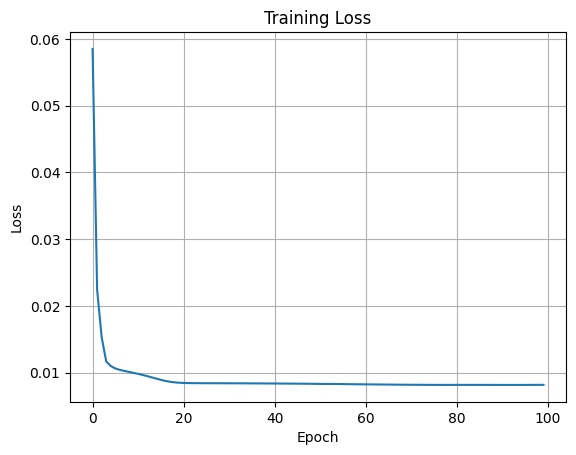

In [9]:
plt.plot(training_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

### Now that the model has finished training, let's see what it's predictions are on the training data.

In [10]:
def test_RNN(model, dataloader, seq_len, device=device):
    # store predictions in an array
    predictions = np.empty([len(dataloader)+seq_len, 1])

    # first seq_len entries not available
    predictions[:seq_len] = np.nan

    model.eval()

    with torch.no_grad():
        idx = seq_len
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            
            # make prediction
            out, _ = model(x)

            # add prediction to array
            predictions[idx] = out.item()
            idx += 1

    return predictions


# see how the final model performs on the training data
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
train_prediction = scaler.inverse_transform(test_RNN(model, train_loader, seq_len=7))

train_data["Predicted"] = train_prediction
train_data.rename(columns={"TMAX": "True"}, inplace=True)
train_data

,True,NORM,Predicted
DATE,,,
2005-01-01,51.0,0.519231,NaN
2005-01-02,34.0,0.355769,NaN
2005-01-03,49.0,0.500000,NaN
2005-01-04,28.0,0.298077,NaN
2005-01-05,7.0,0.096154,NaN
...,...,...,...
2019-04-07,70.0,0.701923,64.941358
2019-04-08,74.0,0.740385,68.443851
2019-04-09,78.0,0.778846,71.576059


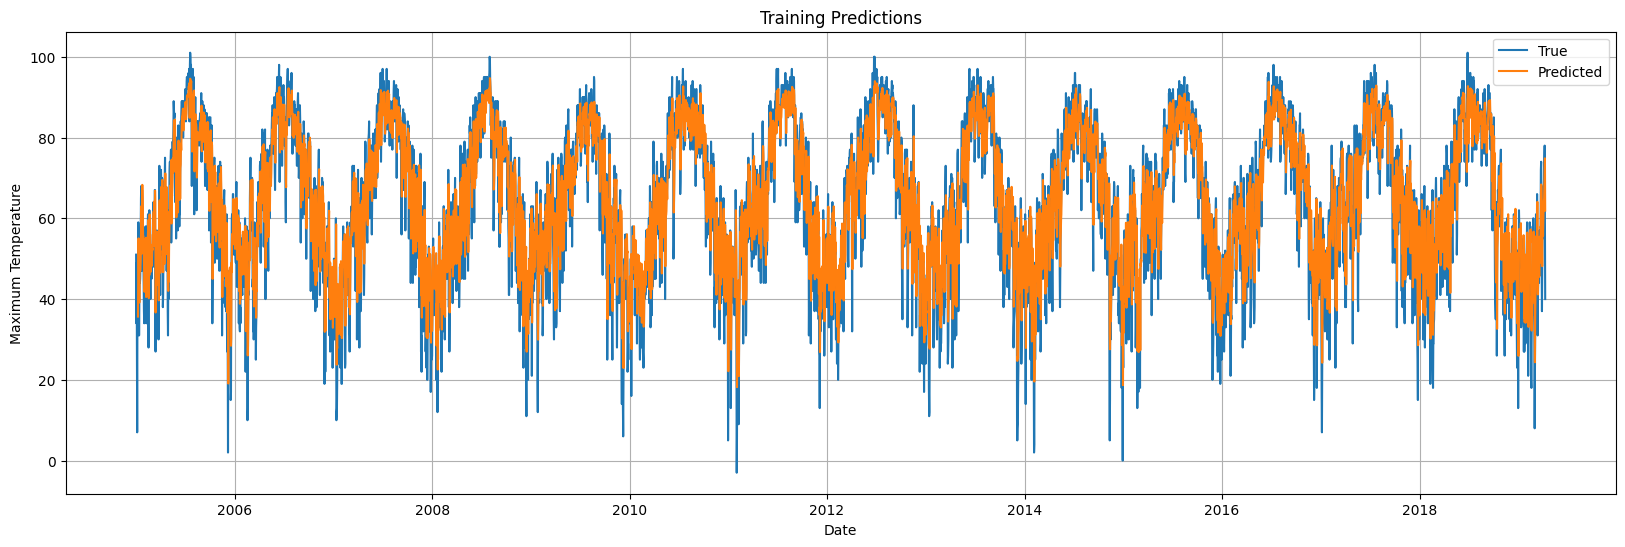

In [11]:
def plot_predictions(df, columns, sample_type, figsize=(8,6)):
    fig = plt.figure(figsize=figsize)
    for col in columns:
        plt.plot(df[col], label=col)
    
    plt.title(f"{sample_type} Predictions")
    plt.xlabel("Date")
    plt.ylabel("Maximum Temperature")
    plt.legend()
    plt.grid()
    plt.close()
    return fig

plot_predictions(train_data, ["True", "Predicted"], "Training", figsize=(20,6))

### Finally, we can test the model to see how well it performs on unseen data. As with the training data, we start by loading it from the csv file.

In [12]:
test_data = pd.read_csv('../Project1/merged_data/denver_weather_test.csv')
test_data["DATE"] = pd.to_datetime(test_data["DATE"])
test_data.set_index("DATE", inplace=True)
test_data = test_data[test_data["STATION"]==0]
test_data = pd.DataFrame(test_data["TMAX"])
test_data["NORM"] = scaler.transform(test_data["TMAX"].values.reshape(-1,1))
print(test_data.head())

test_dataset = TimeSeries(test_data["NORM"].values, seq_len=7)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

            TMAX      NORM
DATE                      
2022-04-03  50.0  0.509615
2022-04-04  65.0  0.653846
2022-04-05  60.0  0.605769
2022-04-06  46.0  0.471154
2022-04-07  50.0  0.509615


### Now we can test its performance on unseen data.

In [13]:
# test the model on unseen data and rescale
test_predictions = scaler.inverse_transform(test_RNN(model, test_loader, seq_len=7))

test_data["Predicted"] = test_predictions


test_data.rename(columns={"TMAX": "True"}, inplace=True)
test_data

,True,NORM,Predicted
DATE,,,
2022-04-03,50.0,0.509615,NaN
2022-04-04,65.0,0.653846,NaN
2022-04-05,60.0,0.605769,NaN
2022-04-06,46.0,0.471154,NaN
2022-04-07,50.0,0.509615,NaN
...,...,...,...
2025-03-30,52.0,0.528846,61.590818
2025-03-31,61.0,0.615385,59.908435
2025-04-01,51.0,0.519231,65.831232


### Lets plot the performance of the model for the test data

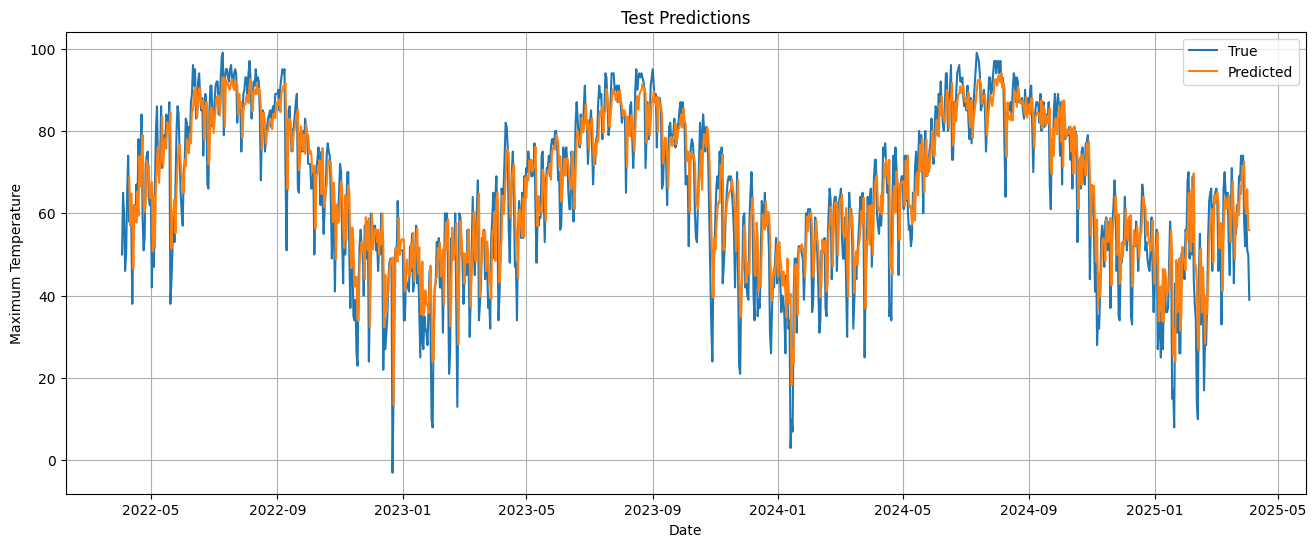

In [14]:
plot_predictions(test_data, ["True", "Predicted"], "Test", figsize=(16,6))